In [1]:
import os
import shutil

from PIL import Image

import torch

import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

import json

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import torch.cuda as cuda

import torch.nn.functional as F

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

from tensorboardX import SummaryWriter

In [2]:
print(torch.__version__)

2.0.1+cu118


Train Data

In [3]:
clips = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\clips'
new_frames = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\frames'

In [4]:
''' create a new name for each frame: here the directories' names
e.g. 'clips/0531\\1492629775931278791\\20.jpg' becomes  '0531_1492629775931278791.jpg' '''

for i in os.listdir(clips):
    # print(os.listdir(os.path.join(clips, i)))
    for j in os.listdir(os.path.join(clips, i)):
        # print('y = ',j)
        for k in os.listdir(os.path.join(clips,i,j)):
            # get the 20th frame
            frame = os.path.join(clips, i, j, k)
            # print(frame)
            if frame.endswith('20.jpg'):
                tmp = frame[:-7].split('\\')[-2:]
                # print(tmp)
                new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
                new_file = os.path.join(new_frames, new_fn)
                if os.path.exists(new_file):
                    print('File already exists. Skipping.')
                else:
                    new_file = os.path.normpath(new_file)
                    print('New File:', new_file)
                    shutil.copy(frame, new_file)

File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File alr

In [5]:
'''
Generates and writes the corresponding lane masks for the given images
'''
# create a mask of all zeros

def generate_lane_mask(row, training_set):
    
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane: 1, non-lane: 0
    for lane in lanes:    
        '''
        -2 indicates no line in the specified point, so we omit the points from lane markings list
        ''' 
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        # add lane markings to the mask we created
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)
        
        # write the lane mask to the desired directory
        if training_set:   
            path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\lane-masks'
        else:
            path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test\\lane-masks'
        '''
            name each mask according to its image's name. 
            e.g. 'clips\\0531\\1492629775931278791\\20.jpg' becomes '0531_1492629775931278791.jpg'
        '''
        tmp = raw_file[:-7].split('/')[-2:]
        mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(path, mask_fname)
        cv2.imwrite(new_file, mask)
        
    return mask_fname

In [6]:
def load_json_file(file_path):
    """Loads a JSON file and returns a Pandas DataFrame."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

df_0601 = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\label_data_0601.json')
df_0313 = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\label_data_0313.json')
df_0531 = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\label_data_0531.json')

df = pd.concat([df_0601, df_0313, df_0531])

print(df)

                                                 lanes  \
0    [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, ...   
1    [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 558,...   
2    [[-2, -2, -2, -2, -2, 629, 620, 611, 602, 590,...   
3    [[-2, -2, -2, -2, -2, -2, -2, -2, 552, 530, 50...   
4    [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, ...   
..                                                 ...   
353  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, 584, 549...   
354  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, 604, 559...   
355  [[-2, -2, -2, -2, -2, -2, -2, 613, 601, 587, 5...   
356  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, ...   
357  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 560,...   

                                             h_samples  \
0    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
1    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
2    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
3    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
4    [160, 17

In [7]:
# generate masks based on the json files above
for index, row in df.iterrows():
    # generate the lane mask for each frame
    generate_lane_mask(row, training_set=True)
    if index%200 == 0:
        print('Row: ', index)

Row:  0
Row:  200
Row:  400
Row:  0
Row:  200
Row:  400
Row:  600
Row:  800
Row:  1000
Row:  1200
Row:  1400
Row:  1600
Row:  1800
Row:  2000
Row:  2200
Row:  2400
Row:  2600
Row:  2800
Row:  0
Row:  200


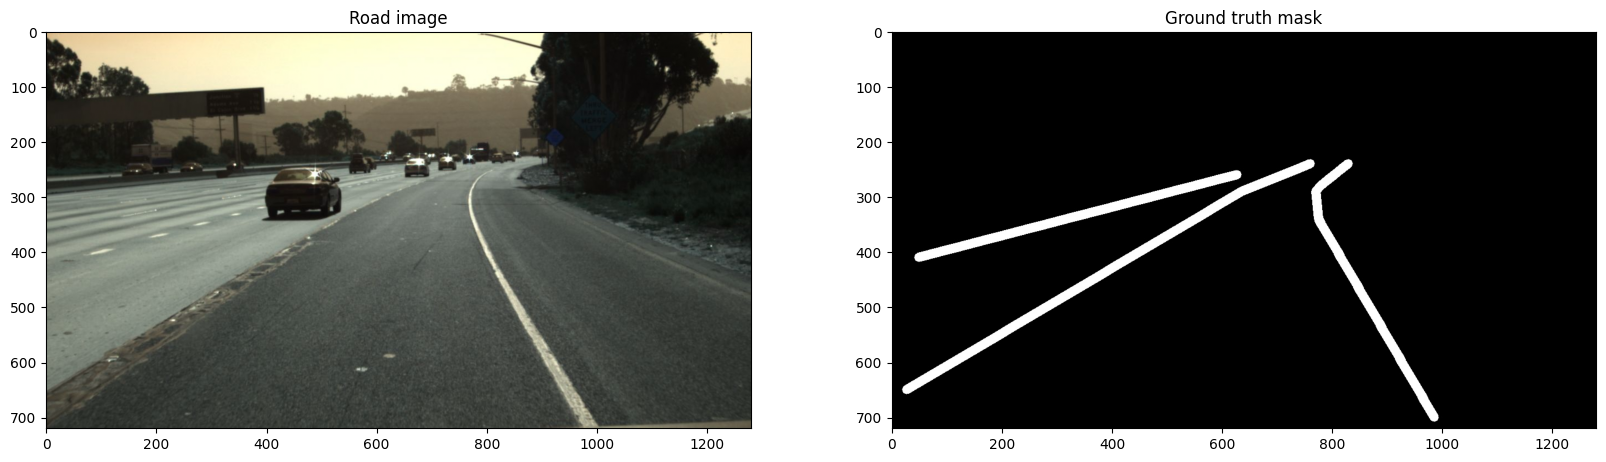

In [8]:
# visualize an example image and its corresponding lane mask
img_mask = cv2.imread('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\lane-masks\\0313-1_60.jpg')
img_color = cv2.imread('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\frames\\0313-1_60.jpg')

# training set
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_color/255.)
plt.title('Road image')

plt.subplot(1, 2, 2)
plt.imshow(img_mask/255., cmap='gray')
plt.title('Ground truth mask')

plt.show()

In [9]:
# check if we have the same image-mask pairs in the training set
images_path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\frames'
masks_path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\lane-masks'
assert os.listdir(images_path) == os.listdir(masks_path)

In [10]:
class LaneDataset(Dataset):
    def __init__(self, images_path, masks_path, transform):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.image_list = os.listdir(images_path)
        self.mask_list = os.listdir(masks_path)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        mask_name = self.mask_list[idx]
        image = Image.open(os.path.join(self.images_path, image_name))
        mask = Image.open(os.path.join(self.masks_path, mask_name)).convert('L')

        if self.transform:
            image = self.transform(image)

        mask_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        mask = mask_transform(mask)

        return image, mask

In [11]:
class ResNetLaneDetection(nn.Module):
    def __init__(self):
        super(ResNetLaneDetection, self).__init__()
        resnet = models.resnet18(weights=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 224 * 224)
        

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 1, 224, 224)

        return x

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data_dir = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training'
images_path = os.path.join(train_data_dir, 'frames')
masks_path = os.path.join(train_data_dir, 'lane-masks')

train_dataset = LaneDataset(images_path, masks_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [13]:
cuda.empty_cache()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetLaneDetection().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Pranshu\MS_Colleges\SRH_Hiedelberg\Semester_4\Master_Thesis\Topic\Prof_Swati_Topics\Lane_Detection\TF_LD_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(device)

cpu


### Calculate Intersection over Union (IoU)

In [16]:
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()  # Convert to binary mask (assuming you used sigmoid activation)
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)  # Add a small epsilon to avoid division by zero

    return iou

### Train Model function

In [18]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs, log_dir='./logs'):
    model.train()
    writer = SummaryWriter(log_dir)
    step = 0

    loss_values = []   # List to store loss values per step/epoch
    iou_values = []    # List to store IoU values per step/epoch
    f1_values = []     # List to store F1 scores per step/epoch
    recall_values = [] # List to store recall scores per step/epoch
    precision_values = []  # List to store precision scores per step/epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_iou = 0.0  # Track IoU
        running_f1 = 0.0
        running_recall = 0.0
        running_precision = 0.0

        for i, (inputs, masks) in enumerate(dataloader):
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                # Calculate IoU
                preds = torch.sigmoid(outputs) > 0.5
                iou = calculate_iou(preds, masks)
                running_iou += iou.item()

                # Convert predictions and masks to binary format
                preds_binary = preds.float()  # Convert to 0 or 1
                masks_binary = masks.float()  # Convert to 0 or 1

                # Calculate F1 score, recall, and precision for this batch
                batch_f1, batch_recall, batch_precision, _ = precision_recall_fscore_support(
                    masks_binary.cpu().numpy().flatten().astype(int),
                    preds_binary.cpu().numpy().flatten().astype(int),
                    average="binary"
                )
                
                running_f1 += batch_f1
                running_recall += batch_recall
                running_precision += batch_precision

                running_loss += loss.item()

                if i % 10 == 9:  # Print every 10 mini-batches
                    print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(dataloader)}, Loss: {running_loss/10:.4f}, IoU: {running_iou/10:.4f}")
                    writer.add_scalar('Loss/train', running_loss/10, step)
                    writer.add_scalar('IoU/train', running_iou/10, step)

                    running_loss = 0.0
                    running_iou = 0.0

                step += 1

        # Calculate the average F1 score, recall, and precision for the entire epoch
        avg_f1 = running_f1 / len(dataloader)
        avg_recall = running_recall / len(dataloader)
        avg_precision = running_precision / len(dataloader)

        # Store loss, IoU, F1, recall, and precision values
        loss_values.append(running_loss / len(dataloader))
        iou_values.append(running_iou / len(dataloader))
        f1_values.append(avg_f1)
        recall_values.append(avg_recall)
        precision_values.append(avg_precision)

        writer.add_scalar('F1/train', avg_f1, epoch)
        writer.add_scalar('Recall/train', avg_recall, epoch)
        writer.add_scalar('Precision/train', avg_precision, epoch)

        # Check if this is the final epoch and print the IoU
        if epoch == num_epochs - 1:
            final_iou = running_iou / len(dataloader)
            print(f"Final Epoch {epoch+1}/{num_epochs}, IoU: {final_iou:.4f}")

    writer.close()
    print('Training complete!')

    # Calculate the overall F1 score, recall, and precision
    overall_f1 = sum(f1_values) / len(f1_values)
    overall_recall = sum(recall_values) / len(recall_values)
    overall_precision = sum(precision_values) / len(precision_values)

    print("Overall F1 Score:", overall_f1)
    print("Overall Recall:", overall_recall)
    print("Overall Precision:", overall_precision)

    # Return loss_values, iou_values, f1_values, recall_values, and precision_values
    return loss_values, iou_values, overall_f1, overall_recall, overall_precision, final_iou

In [19]:
# Start training
loss_values, iou_values, final_f1_values, final_recall_values, final_precision_values, final_iou = train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, log_dir='./logs')

Epoch 1/10, Step 10/227, Loss: 0.3018, IoU: 0.0149
Epoch 1/10, Step 20/227, Loss: 0.1292, IoU: 0.0287
Epoch 1/10, Step 30/227, Loss: 0.1272, IoU: 0.0146
Epoch 1/10, Step 40/227, Loss: 0.1243, IoU: 0.0078
Epoch 1/10, Step 50/227, Loss: 0.1225, IoU: 0.0109
Epoch 1/10, Step 60/227, Loss: 0.1144, IoU: 0.0530
Epoch 1/10, Step 70/227, Loss: 0.1175, IoU: 0.0619
Epoch 1/10, Step 80/227, Loss: 0.1191, IoU: 0.0354
Epoch 1/10, Step 90/227, Loss: 0.1154, IoU: 0.0874
Epoch 1/10, Step 100/227, Loss: 0.1148, IoU: 0.0827
Epoch 1/10, Step 110/227, Loss: 0.1121, IoU: 0.0934
Epoch 1/10, Step 120/227, Loss: 0.1167, IoU: 0.1085
Epoch 1/10, Step 130/227, Loss: 0.1109, IoU: 0.0798
Epoch 1/10, Step 140/227, Loss: 0.1082, IoU: 0.1059
Epoch 1/10, Step 150/227, Loss: 0.1091, IoU: 0.1172
Epoch 1/10, Step 160/227, Loss: 0.1007, IoU: 0.1279
Epoch 1/10, Step 170/227, Loss: 0.1016, IoU: 0.1358
Epoch 1/10, Step 180/227, Loss: 0.0991, IoU: 0.1713
Epoch 1/10, Step 190/227, Loss: 0.1013, IoU: 0.1593
Epoch 1/10, Step 200/

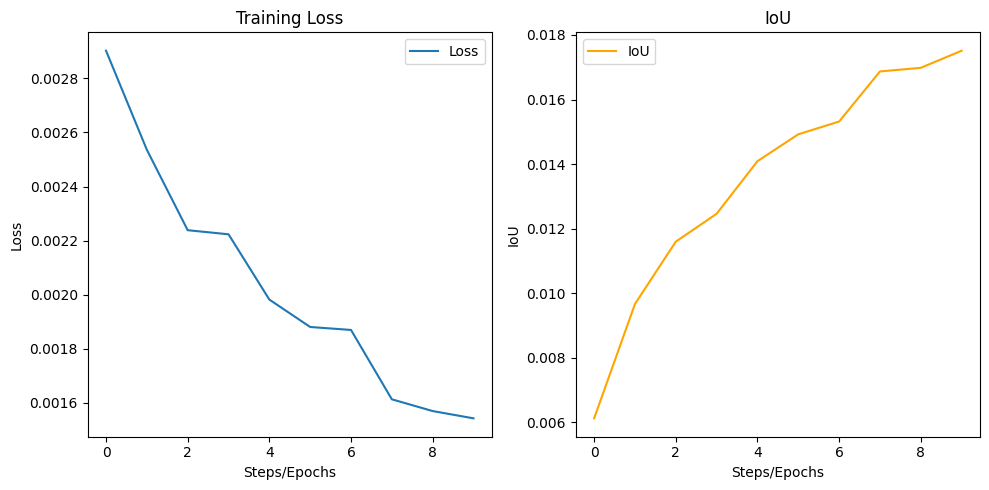

In [20]:
# Assuming you have stored loss and IoU values during training

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss')
plt.xlabel('Steps/Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iou_values, label='IoU', color='orange')
plt.xlabel('Steps/Epochs')
plt.ylabel('IoU')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.show()

### Save the model

In [31]:
torch.save(model.state_dict(), 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\models\\resnet_18_model.pth')

### Test Data 

In [32]:
# Replace the directory path with the one you want to create
base_directory = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set'

# Create main folder 'tusimple_preprocessed'
main_folder = os.path.join(base_directory, 'tusimple_preprocessed_test')
os.makedirs(main_folder, exist_ok=True)

# Create 'frames' and 'lane-masks' folders inside 'training'
frames_folder = os.path.join(main_folder, 'frames')
lane_masks_folder = os.path.join(main_folder, 'lane-masks')
os.makedirs(frames_folder, exist_ok=True)
os.makedirs(lane_masks_folder, exist_ok=True)

In [33]:
test_clips = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\clips'
new_test_frames = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test\\frames'

### Preprocessed Test Data Directory 

In [34]:
''' create a new name for each frame: here the directories' names
e.g. 'clips/0531/1492629775931278791/20.jpg' becomes  '0531_1492629775931278791.jpg' '''

for i in os.listdir(test_clips):
    for j in os.listdir(os.path.join(test_clips, i)):
        for k in os.listdir(os.path.join(test_clips, i, j)):
            # get the 20th frame
            frame = os.path.join(test_clips, i, j, k)
            frame = os.path.normpath(frame)  # Normalize the path
            if frame.endswith('20.jpg'):
                tmp = frame[:-7].split(os.path.sep)[-2:]
                new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
                new_file = os.path.join(new_test_frames, new_fn)
                new_file = os.path.normpath(new_file)  # Normalize the path
                shutil.copy(frame, new_file)

### Load the JSON file

In [35]:
df_test_json = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_label.json')

In [36]:
# Define the LaneDataset class for test data
class TestLaneDataset(Dataset):
    def __init__(self, images_path, transform):  # transform = None previously
        self.images_path = images_path
        self.transform = transform
        self.image_list = os.listdir(images_path)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image = Image.open(os.path.join(self.images_path, image_name))

        # # Resize image to desired dimensions
        # image = image.resize((224, 224), Image.LANCZOS)
        # mask = mask.resize((224, 224), Image.LANCZOS)

        if self.transform:
            image = self.transform(image)

        return image, image_name

Transform Images & pass Test Dataset

In [37]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data_dir = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test'
images_path = os.path.join(test_data_dir, 'frames')

test_dataset = TestLaneDataset(images_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [39]:
# Load the saved model
model_path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\models\\resnet_18_model.pth'

loaded_model = ResNetLaneDetection()

loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

# Move the model to the same device as the input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

ResNetLaneDetection(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [40]:
def predict_and_visualize(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for idx, (inputs, image_names) in enumerate(dataloader):
            if idx >= num_images:
                break  # Stop after displaying top num_images images

            inputs = inputs.to(device)  # Move input data to the same device as the model
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            pred_mask = preds.squeeze().cpu().numpy().astype(np.uint8)  # Convert to uint8

            # Load the original image
            original_image_path = os.path.join(images_path, image_names[0])
            original_image = cv2.imread(original_image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Resize the predicted mask to match the dimensions of the original image
            pred_mask_resized = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Create a black background and overlay the white lane mask
            black_background = np.zeros_like(original_image)
            black_background[pred_mask_resized == 1] = [255, 255, 255]  # Set detected lane to white

            # Blend the images to visualize the lanes
            blended_image = cv2.addWeighted(original_image, 0.7, black_background, 0.3, 0)

            # Combine the original image and predicted image side by side
            combined_image = np.concatenate((original_image, blended_image), axis=1)

            # Visualize the original image and predicted image side by side
            plt.figure(figsize=(15, 6))
            plt.imshow(combined_image)
            plt.axis('off')
            plt.title(f'Top 10 Test Images: {idx + 1}')
            plt.show()

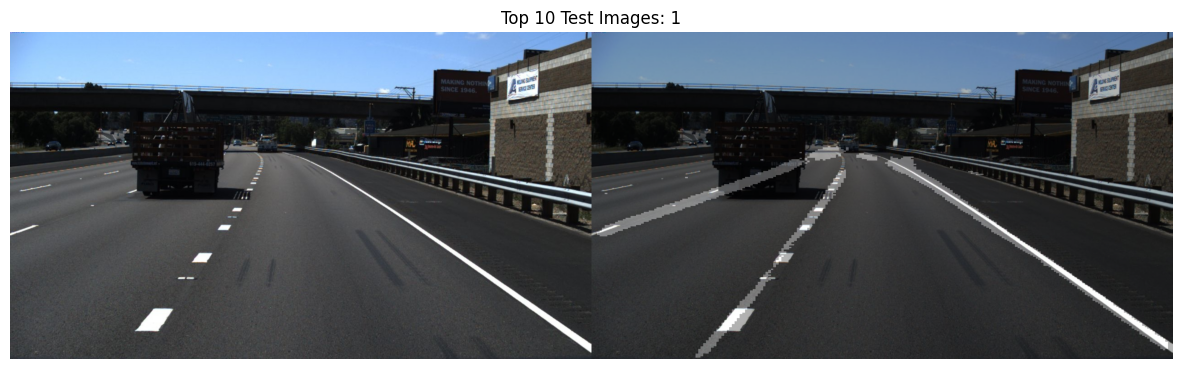

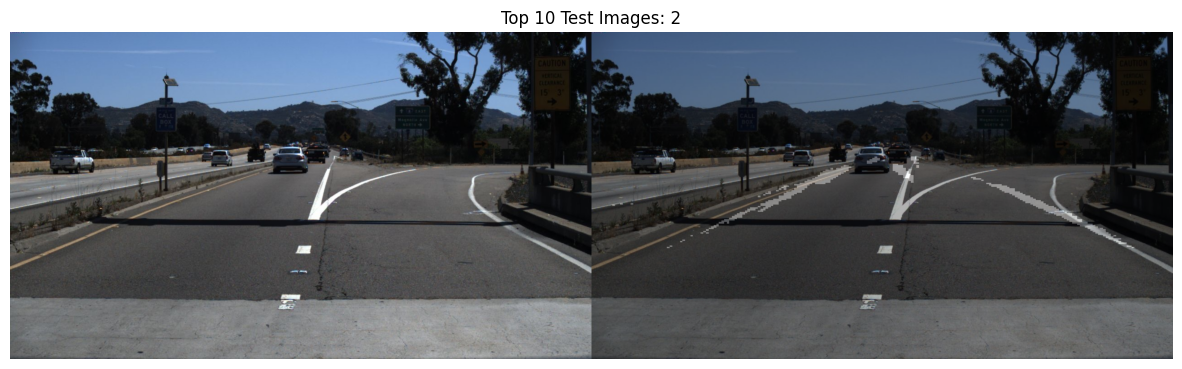

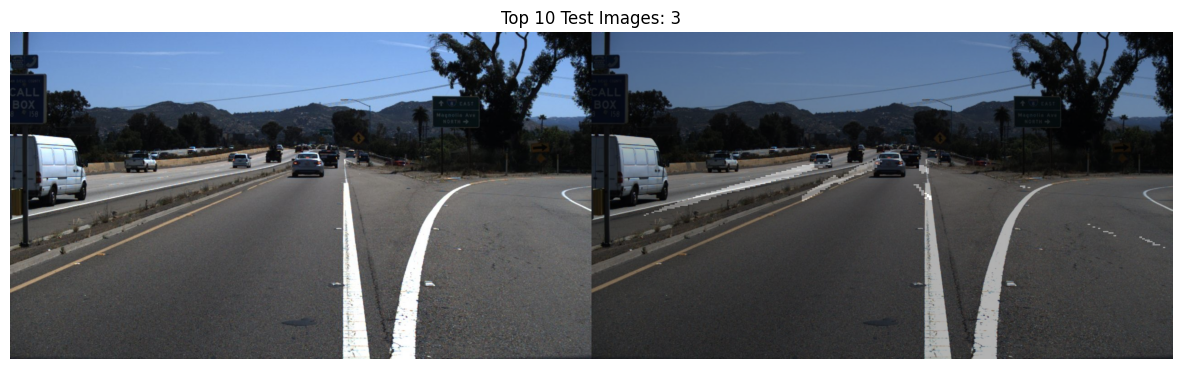

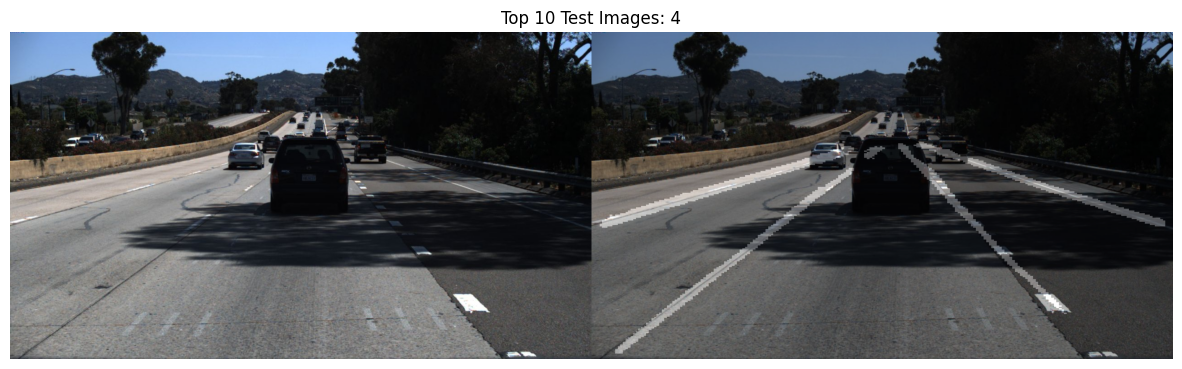

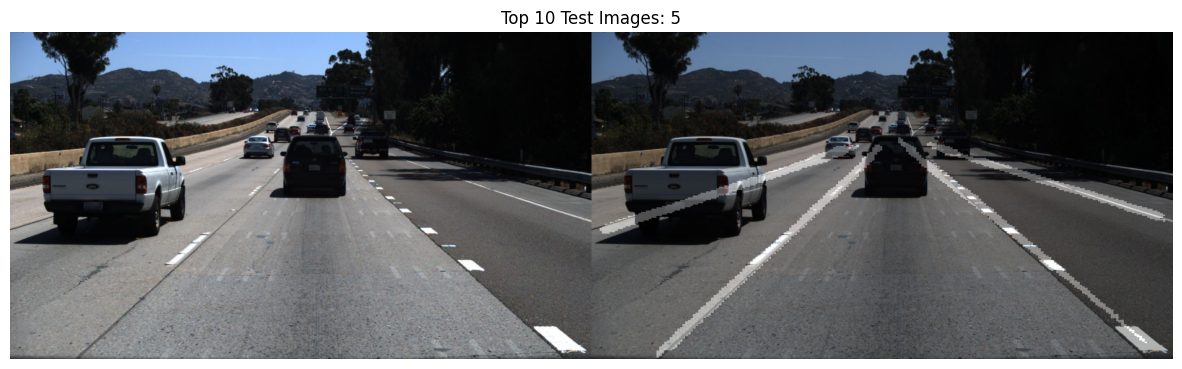

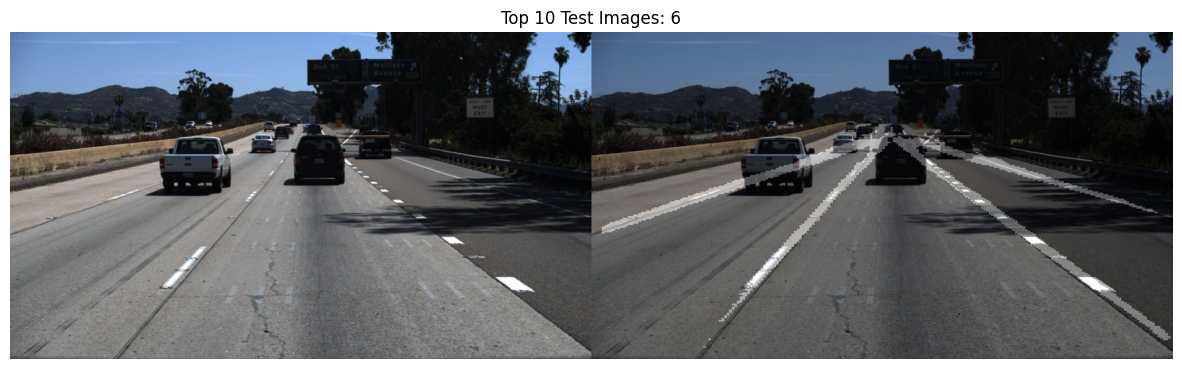

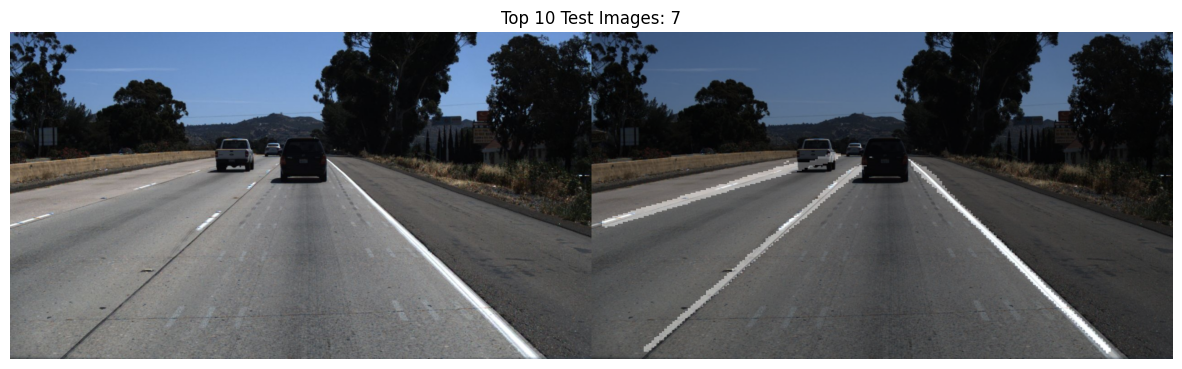

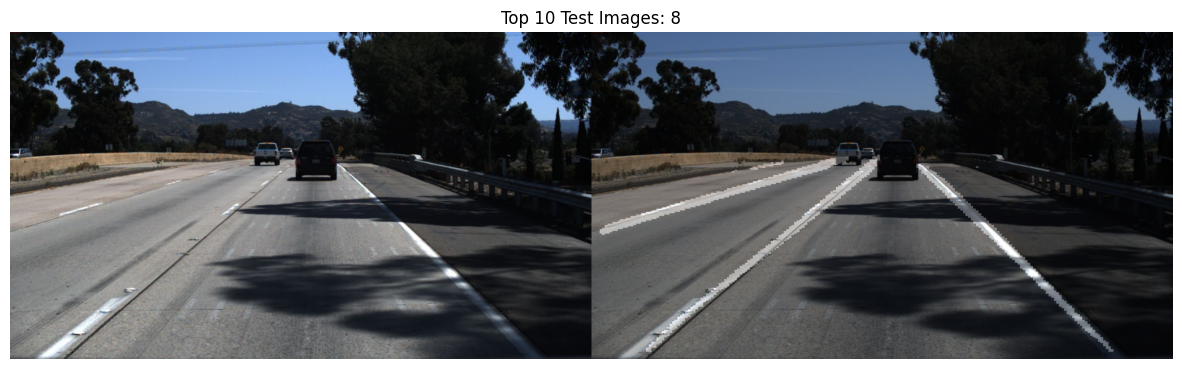

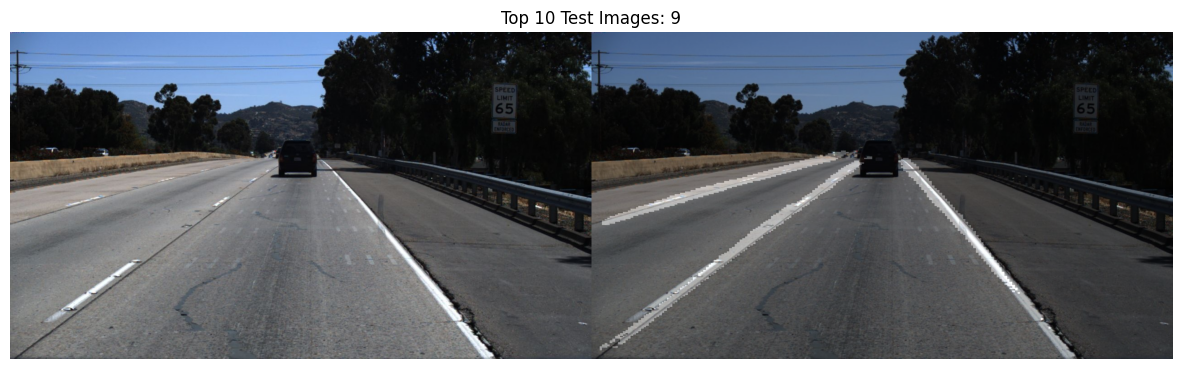

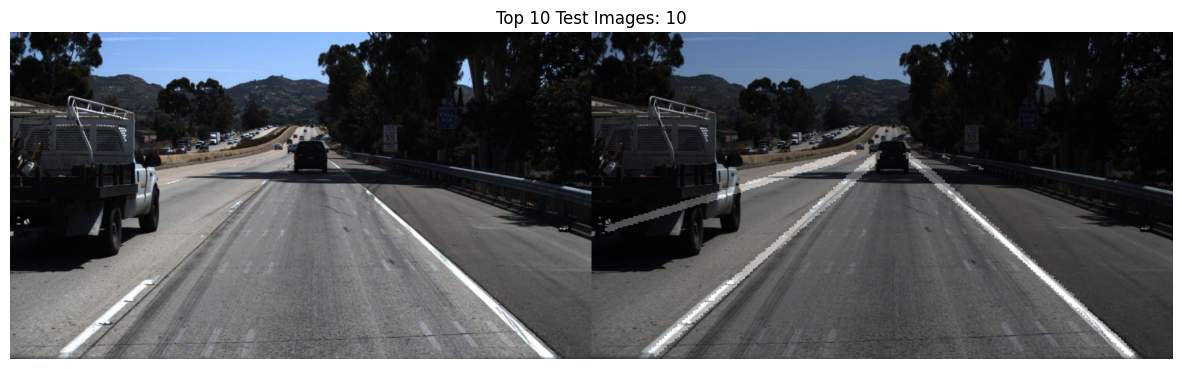

In [41]:
# Predict and visualize top 10 test images and predictions
predict_and_visualize(model, test_loader, num_images=10)